In [139]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from control.matlab import tf, step, lsim

from utils import utils, dbm_math

%matplotlib inline

In [140]:
data1 = utils.read_mat("/home/matthias/Downloads/ex3/ex3_system1_data.mat")
data2 = utils.read_mat("/home/matthias/Downloads/ex3/ex3_system2_data.mat")

display(data1.keys())
display(data2.keys())

dict_keys(['None', 'README', 't1', 't2', 'u1', 'u2', 'y1', 'y2'])

dict_keys(['README', 't1', 't2', 't3', 'u1', 'u2', 'u3', 'y1', 'y2', 'y3'])

In [147]:
# Constants
NA = 4
NB = 5

HA_NUM = 3
HA_FUN = lambda x,p: x**p

In [148]:
def hammerstein_s(na,nb,y,u,k,func,ha_num):
    sy = np.zeros((1,na))
    su = np.zeros((1,nb+1))

    for i in range(k + 1):
        index_a: int = k - i - 1
        index_b: int = k - i

        if index_a >= 0:
            try:
                sy[index_a] = float(y[i])
            except Exception:
                pass
        if index_b >= 0:
            try:
                su[index_b] = float(u[i])
            except Exception as e:
                pass
    
    s = np.append(sy,su)

    for i in range(1,ha_num):
        su_p = [func(e,i) for e in su]
        s = np.append(s,su_p)

    return s


In [149]:
def rec_hammerstein(
    n_a: int,
    n_b: int,
    k: int,
    y: np.array,
    u: np.array,
    p_hat_k_1: np.array = None,
    P_k_1: np.array = None,
    alpha: float = 10e6,
) -> tuple[np.array, np.array]:
    """Recursive least squares algorithm.
    p_hat_k_1 and P_k_1 are optional parameters.
    If they are not provided, they are recursivly calculated.

    Args:
        n_a (int): Order of the denominator
        n_b (int): Order of the numerator
        k (int): Current index
        y (np.array): Output vector
        u (np.array): Input vector
        p_hat_k_1 (np.array, Optional): Parameter vector
        P_k_1 (np.array, Optional): Covariance matrix
        alpha (float, Optional): Forgetting factor


    Returns:
        p_k (np.array): Parameter vector
        P_k (np.array): Covariance matrix
    """
    if k < 0:
        p_init = np.zeros(n_a + (n_b + 1)*HA_NUM).reshape(-1, 1)
        P_init = np.eye(n_a + (n_b + 1)*HA_NUM) * alpha
        return p_init, P_init

    if P_k_1 is None or p_hat_k_1 is None:
        p_hat_k_1, P_k_1 = rec_hammerstein(n_a, n_b, k - 1, y, u)

    s_k = hammerstein_s(n_a, n_b, y, u, k, HA_FUN,HA_NUM).reshape(-1, 1)
    k_k = (np.dot(P_k_1, s_k)) / (1 + np.dot(s_k.T, np.dot(P_k_1, s_k)))
    P_K = P_k_1 - np.dot(k_k, np.dot(s_k.T, P_k_1))
    p_hat_k = p_hat_k_1 + k_k * (y[k] - np.dot(s_k.T, p_hat_k_1))

    return p_hat_k, P_K

In [150]:
def ex3_recursive_lsq_hammerstein_sim(t, u, y0, na,nb,ha_num,ha_fun, pval):
    """"""
    y = np.zeros(len(u))
    y[0] = y0

    for k in range(1, len(t)):
        sy = np.zeros(na)
        su = np.zeros(nb + 1)

        iy = [i for i in np.arange(k - 1, k - na - 1, -1) if i  >= 0]
        iu = [i for i in np.arange(k, k - nb - 1, -1) if i >= 0]

        if len(iy) > 0:
            sy[:len(iy)] = [y[i] for i in iy]
        if len(iu) > 0:
            su[:len(iu)] = [u[i] for i in iu]
            for j in range(2, ha_num + 1):
                sh = np.zeros(nb + 1)
                sh[:len(iu)] = [ha_fun(u[i], j) for i in iu]
                su = np.concatenate((su, sh))

        S = np.array(np.concatenate((sy, su))).reshape(-1, 1)   

        y[k] = np.dot(pval, S)

    return y


In [151]:
t = data1.t1
y = data1.y1
u = data1.u1
Ts = t[1] - t[0]

pk_list = []
Pk_list = []
pk, Pk = rec_hammerstein(NA, NB, -1, y, u)

for i in range(len(t)):
    pk, Pk = rec_hammerstein(NA, NB, i, y, u, pk, Pk)
    pk_list.append(pk)
    Pk_list.append(Pk)

    if i > 1:
        dpest = pk_list[-1] - pk_list[-2]
        dnorm = np.linalg.norm(dpest)


p_hat = pk_list[-1].flatten()
print("Estimated Parameters: ", p_hat)

y_pred = ex3_recursive_lsq_hammerstein_sim(t, u, y[0], NA, NB, HA_NUM, HA_FUN, p_hat)

Estimated Parameters:  [ 2.36379019e-01  2.36379019e-01  2.36379019e-01  2.36379019e-01
  1.90765618e-04  1.90765618e-04  1.90765635e-04  1.90765635e-04
  1.90765651e-04  1.90765651e-04  6.18590809e-03  6.18590809e-03
  6.18590809e-03  6.18590809e-03  6.18590809e-03  6.18590809e-03
 -7.02172883e-01 -7.02172883e-01 -7.02172883e-01 -7.02172883e-01
 -7.02172883e-01 -7.02172883e-01]


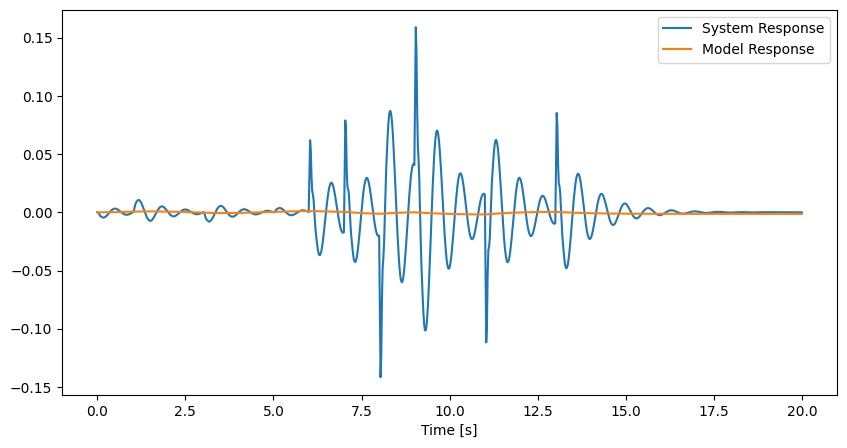

In [152]:
plt.figure(figsize=(10, 5))
plt.plot(t,y, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t, y_pred,label="Model Response")
plt.legend()
plt.show()
